# Simple object detection using TensorFlow Hub & Object Detection API

In [123]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import io

from six import BytesIO
from six.moves.urllib.request import urlopen
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
import tensorflow_hub as hub

In [124]:
tf.__version__

'2.8.0'

In [125]:
# Clone the tensorflow models repository
!git clone https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


**TF Object Detection API**

In [126]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-comput



  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.


In [127]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [128]:
def load_image_into_numpy_array(path):
  
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size

  return np.array(image.getdata()).reshape((1, im_height, im_width, 3)).astype(np.uint8)

Load the label map which corresponds index numbers to category names

In [129]:
label_path = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(label_path, use_display_name=True)

Object detection model can be found at 
https://tfhub.dev/s?module-type=image-object-detection


Model speed & COCO mAP lookup table can be found at https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

Load the pratrained model on TF Hub

In [130]:
model_name = 'CenterNet HourGlass104 512x512' 
model_url_at_tfhub = 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1'

In [131]:
hub_model = hub.load(model_url_at_tfhub)

# Model Inference

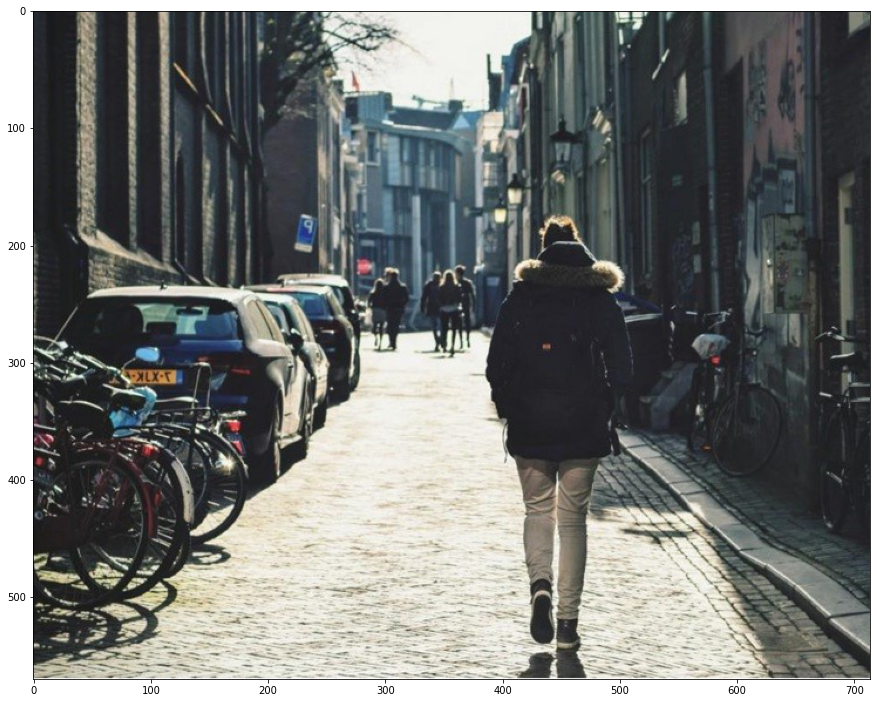

In [135]:
image_path = './street.jpg'
image_np = load_image_into_numpy_array(image_path)

# Try out to see if detector still works after fliping
flip_image_horizontally = True

if (flip_image_horizontally):
  image_np = tf.image.flip_left_right(image_np).numpy()

plt.figure(figsize=(15,17))
plt.imshow(image_np[0])
plt.show()

In [136]:
# running inference
results = hub_model(image_np)

# see model documentation for output format
result = {key:value.numpy() for key,value in results.items()}
print(result.keys())

dict_keys(['detection_boxes', 'num_detections', 'detection_classes', 'detection_scores'])


Visualizing the result

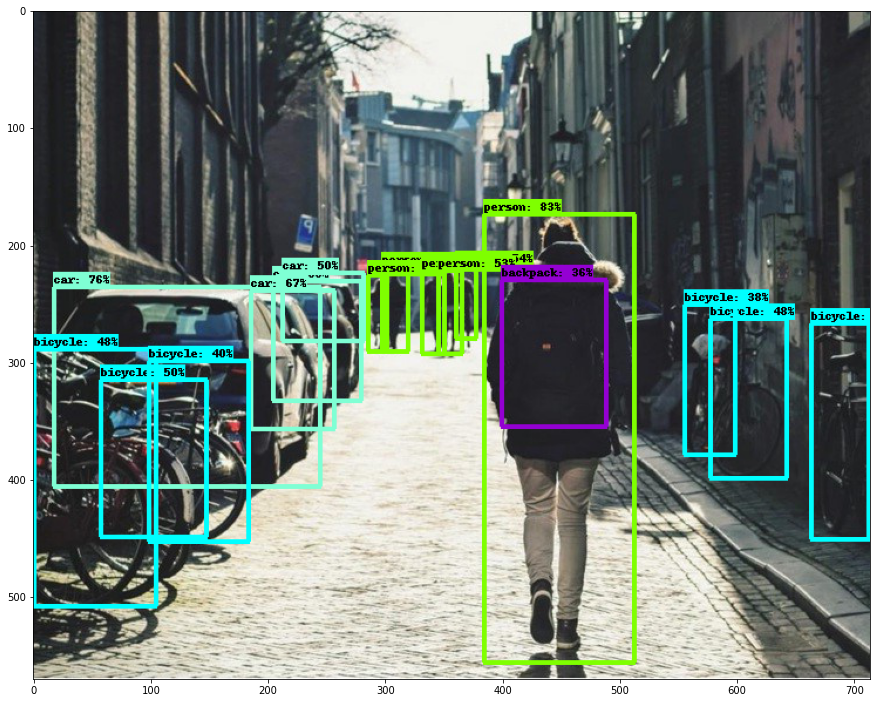

In [137]:
label_id_offset = 0
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(15,17))
plt.imshow(image_np_with_detections[0])
plt.show()